In [55]:
import rust as rs
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

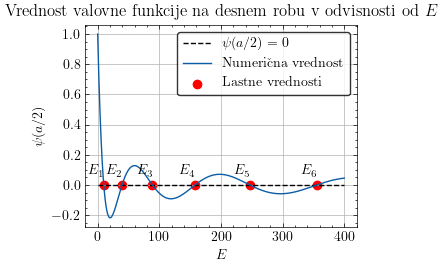

In [56]:


import scipy.optimize as opt
import scipy.interpolate as interp

n = 1000
k_s = np.linspace(0, 20, n)
t = np.linspace(0, 1, n)

solutions = np.ones_like(k_s)
for i, k in enumerate(k_s):
    # f = lambda x, t: schrodinger(x, k)
    x = rs.sch_rk4(k**2, [0., 1.], t)
    solutions[i] = x[-1][0]

zero_crossings = np.where(np.diff(np.sign(solutions)))[0]
k_zeros = np.array([opt.brentq(lambda k: interp.interp1d(k_s, solutions)(k), k_s[i], k_s[i+1]) for i in zero_crossings])


plt.hlines(0, 0, 20**2, linestyles='dashed', colors='black', label='$\\psi(a/2) = 0$')
plt.plot(k_s**2, solutions, label='Numerična vrednost')

plt.grid()
plt.xlabel('$E$')
plt.ylabel('$\\psi(a/2)$')
plt.title('Vrednost valovne funkcije na desnem robu v odvisnosti od $E$')
plt.scatter(k_zeros**2, np.zeros_like(k_zeros), color='red', label='Lastne vrednosti')
for i, k in enumerate(k_zeros):
    label = '$E_{' + str(i+1) + '}$'
    plt.text(k**2 - 0.1, 0.05, label,  verticalalignment='bottom', horizontalalignment='right')

plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.savefig('graphs/vija.pdf', dpi=512)




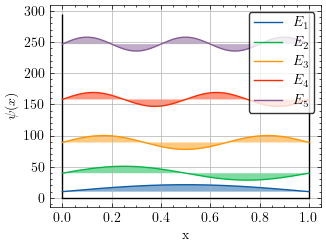

In [57]:
plt.plot(np.linspace(0,1), [0]*50, c='black')
plt.vlines([0,1], 0, 295, colors='black')
scale = 70

for i, k in enumerate(k_zeros[:-1]):
    sol = np.array(rs.shooter(0, 0, 1, 0.5, t, 1e-5, k**2, False, False))[:,0]
    plt.plot(t, (1+i)*scale*sol + k**2, c=f'C{i}', label='$E_{' + str(i+1) + '}$')
    plt.fill_between(t, k**2, (1+i)*scale*sol + k**2, alpha=0.5)

plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('x')
plt.ylabel('$\\psi (x)$')
plt.savefig('graphs/koncna.pdf', dpi=512)


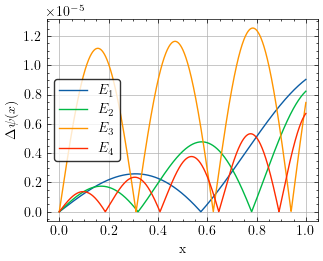

In [58]:
def analytic_infinite_well(x, n):
    return np.sin(n * np.pi * x)


for i, k in enumerate(k_zeros[:4]):
    analytic = analytic_infinite_well(t, i+1)
    sol = np.array(rs.shooter(0, 0, 1, 0.5, t, 1e-5, k**2, False, False))[:,0]
    sol = sol / np.max(np.abs(sol))
    plt.plot(t, np.abs(sol - analytic), label=f'$E_{{{i+1}}}$')
    # plt.plot(analytic)
    # plt.plot(sol)

plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('x')
plt.ylabel('$\\Delta\\psi (x)$')
plt.savefig('graphs/sh_errs.pdf', dpi=512)

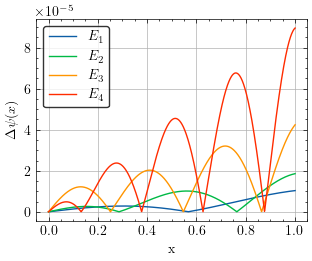

In [59]:
from bvp import fd

def fdv(t, e):
    n = len(t)
    return rs.fd([0]*n, [-e]*n, [0]*n, t, 0, 1e-5)
    # return fd(0, -e, 0, t, 0, 1e-4)

for i in range(4):
    analytic = analytic_infinite_well(t, i+1)
    sol = np.array(fdv(t, k_zeros[i]**2))
    if sol[0] > sol[1]:
        sol = -sol
    sol = sol / np.max(np.abs(sol))
    plt.plot(t, np.abs(sol - analytic), label=f'$E_{{{i+1}}}$')


plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('x')
plt.ylabel('$\\Delta\\psi (x)$')
plt.savefig('graphs/fd_errs.pdf', dpi=512)


In [60]:
from timeit import timeit

sh_err = []
sh_tim = []
fd_err = []
fd_tim = []
for n in range(10,1400):
    t = np.linspace(0, 1, n)
    ts = timeit(lambda: rs.shooter(0, 0, 1, 0.5, t, 1e-5, k_zeros[0]**2, False, False), number=1)
    sh_tim.append(ts)
    ts = timeit(lambda: fdv(t, k_zeros[0]**2), number=1)
    fd_tim.append(ts)
    sol = np.array(fdv(t, k_zeros[0]**2))
    if sol[0] > sol[1]:
        sol = -sol
    try:
        sol = sol / np.max(np.abs(sol))
    except:
        pass
    es = np.max(np.abs(analytic_infinite_well(t, 1) - sol))
    fd_err.append(es)
    sol = np.array(rs.shooter(0, 0, 1, 0.5, t, 1e-5, k_zeros[0]**2, False, False))[:,0]
    try:
        sol = sol / np.max(np.abs(sol))
    except:
        pass
    es = np.max(np.abs(analytic_infinite_well(t, 1) - sol))
    sh_err.append(es)

print(len(fd_err))
print(len(sh_err))

/tmp/ipykernel_103137/969415002.py:24: RuntimeWarning: invalid value encountered in divide
  sol = sol / np.max(np.abs(sol))


1390
1390


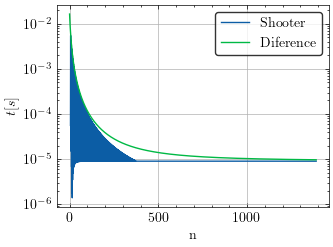

In [61]:
plt.plot(sh_tim, label='Shooter')
plt.plot(fd_tim, label='Diference')
plt.yscale('log')
plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('n')
plt.ylabel('$t [s]$')
plt.savefig('graphs/time.pdf', dpi=512)
plt.clf()

plt.plot(sh_err, label='Shooter')
plt.plot(fd_err, label='Diference')
plt.yscale('log')
plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('n')
plt.ylabel('$t [s]$')
plt.savefig('graphs/err.pdf', dpi=512)

-0.010009099181073289
[0.0006826220116465992, 0.0026946488092322424, 0.005889358881612696, 0.009633293773137323, 0.010057118859749997, 0.010063003235102501, 0.010173669453192763, 0.01019423430275938, 0.010367302821793246, 0.010406541877765876, 0.010637093904114485, 0.010696453065815471, 0.0109817262219455, 0.011062284483668815, 0.011399425395402315, 0.011503208250924522, 0.011887837046789574, 0.012018694880364814, 0.012443881465111186, 0.012608247534886432, 0.013063740289322114, 0.01327126859573775, 0.013743380081309103, 0.014006974686679751, 0.014480175073626419, 0.014814319425657708, 0.015275326138893097, 0.015691902866898387, 0.01613461852733026, 0.016637859149861454, 0.01706545240316487, 0.017649733487926873, 0.018072864856028794, 0.01872440669197846, 0.019158322929372855, 0.01985822778814736, 0.020320829223794953, 0.021047665107180234, 0.021558215027991334, 0.02229078040156827, 0.02286780672335512, 0.023589150826384825, 0.02424660645632687, 0.02494852717718796, 0.02569126540498113

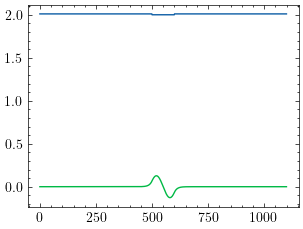

In [62]:
def fdv(t, e):
    n = len(t)
    v = np.array([(-20 if i > 0 and i < 1 else 0) for i in t]) + np.array([-e]*n)
    return rs.fd([0]*n, v, [0]*n, t, 0, 1e-5)

t = np.linspace(-5, 6, 1100)
# plt.plot(fdv(t, 16.45))
# plt.show()

h = t[0] - t[1]
print(h)
n = len(t)
v = np.array([(h**2*100 if i < 0 or i > 1 else 0) for i in t]) + np.array([2]*n)
plt.plot(v)
u = np.array([-1.0]*(n-1))

vals, vecs = rs.fdd(v, u)
plt.plot(vecs[1])
print(vals)
# plt.plot(rs.shooter())
valis = vals

vals = np.array(vals)* np.pi**2 #/ (-h) 
vals = vals*10 / np.abs(h)
# vals = vals**2

6.7310844747821825
26.57094036721985
58.07280084452762
94.99036516705553


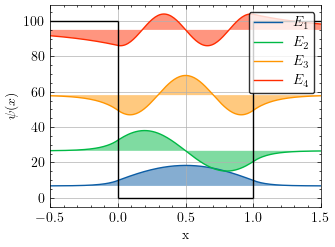

In [63]:

scale = 90
for i, val in enumerate(vals[:4]):
    sol = np.array(vecs[i])
    plt.plot(t, scale*sol + val, c=f'C{i}', label='$E_{' + str(i+1) + '}$')
    plt.fill_between(t, val, scale*sol + val, alpha=0.5)
    print(val)

plt.xlim((-0.5,1.5))
plt.hlines(0, 0, 1, colors='black')
plt.hlines([100, 100], [-0.5, 1], [0, 1.5], colors='black')
plt.vlines([0, 1], [0,0], [100,100], colors='black')
plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('x')
plt.ylabel('$\\psi (x)$')
plt.savefig('graphs/koncna.pdf', dpi=512)

0.0006826220116465992
0.0026946488092322424


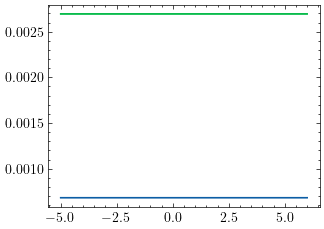

0.0006826220116465992
0.0026946488092322424


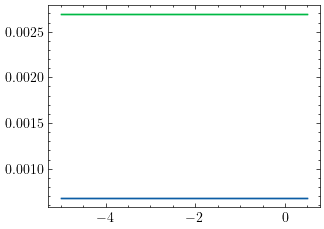

In [64]:
for i, val in enumerate(valis[:2]):
    sol = np.array(rs.shooter(0, 0, 1, 0.5, t, 1e-2, val, False, False, True))
    plt.plot(t, scale*sol + val, c=f'C{i}', label='$E_{' + str(i+1) + '}$')
    # plt.fill_between(t, val, scale*sol + val, alpha=0.5)
    print(val)
plt.show()

for i, val in enumerate(valis[:2]):
    sol = np.array(rs.shooter(0, 0, 1, 0.5, t[:n//2], 1e-2, val, False, False, True))
    plt.plot(t[:n//2], scale*sol + val, c=f'C{i}', label='$E_{' + str(i+1) + '}$')
    # plt.fill_between(t, val, scale*sol + val, alpha=0.5)
    print(val)
plt.show()

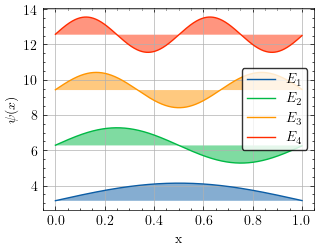

In [66]:
def pentadiagonal_matrix(n):
    A = np.zeros((n, n))

    np.fill_diagonal(A, 6)
    np.fill_diagonal(A[1:], -4)
    np.fill_diagonal(A[:, 1:], -4)
    np.fill_diagonal(A[2:], 1)
    np.fill_diagonal(A[:, 2:], 1)
    A[0][0] = 5
    A[n-1][n-1] = 5

    return A

n = 1000
mat = pentadiagonal_matrix(n)

vals, vecs = np.linalg.eigh(mat)

eig_vectors = []
for vec in vecs:
    avec = np.abs(vec)
    direction = 1
    eigvec = []
    for i in range(1, n-3):
        if avec[i-1] > avec[i] and avec[i] < avec[i+1] and vec[i] < 0:
            direction *= -1
        eigvec.append(avec[i]*direction)
        if avec[i-1] > avec[i] and avec[i] < avec[i+1] and vec[i] > 0:
            direction *= -1
    eig_vectors.append(eigvec/max(eigvec))

# plt.plot(vals**0.25*n)
# plt.plot(vecs[0])
vals=vals**0.25*n
t = np.linspace(0,1,n-4)
scale = 1
for i, val in enumerate(vals[:4]):
    sol = np.array(eig_vectors[i])
    plt.plot(t, scale*sol + val, c=f'C{i}', label='$E_{' + str(i+1) + '}$')
    plt.fill_between(t, val, scale*sol + val, alpha=0.5)
    # print(val)

plt.grid()
plt.legend(
    facecolor="white",    # background color
    edgecolor="black",    # border color
    framealpha=0.8,       # transparency (1 is opaque)
    frameon=True          # ensure the frame is drawn
)
plt.xlabel('x')
plt.ylabel('$\\psi (x)$')
plt.savefig('graphs/exstra.pdf', dpi=512)